<a href="https://colab.research.google.com/github/BaseKan/python_workshop_brh/blob/main/python_broekhuis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algemeen

Code wordt zoveel mogelijk opgedeeld in verschillende functies met het liefst maar één duidelijk doel.

Buiten de functies gebeurt over het algemeen zo min mogelijk, behalve:

*   imports
*   afhandelen commandline arguments
*   aanmaken globale constants (maar géén globale variables!)

Voor Python is een zeer breed geaccepteerde coding standard: Pep8

Het bevat onder andere naming conventions, zoals:
*   Functies, variables, files en folders lower_case_with_underscores
*   Constants ALLCAPS
*   Classes CamelCase

Verder dient meteen duidelijk te zijn wat een functie doet of wat voor data er in een variabele zit. Een naam als *com_server_task_list* is bijvoorbeeld beter dan *task_list*, ookal is de eerste een stuk langer.

Pep8 bevat nog veel meer richtlijnen, maar gelukkig helpt PyCharm je al enorm hierbij.

Voor meer informatie, zie: https://peps.python.org/pep-0008/#naming-conventions 


## List Comprehensions vs For Loops

Python kent een specifieke notatie die in de meeste gevallen for loops kan vervangen, namelijk *list comprehensions*. Het is in Python gangbaar waar mogelijk altijd list comprehensions te gebruiken in plaats van for loops. Het heeft namelijk een stuk leesbaarder en compacter (over het algemeen) en daarnaast is het in bijna alle gevallen ook een stuk sneller.

In [ ]:
rmq_connections = [{'adress': 'SRV-DEV-08', 'user_provided_name': 'bas'}, 
                   {'adress': 'SRV-IAC-30', 'user_provided_name': 'ansible_test'}]

In [ ]:
running_connections = []
for connection in rmq_connections:
  running_connections.append(connection['user_provided_name'])

running_connections

['bas', 'ansible_test']

In [ ]:
running_connections = [connection['user_provided_name'] for connection in rmq_connections]
running_connections

['bas', 'ansible_test']

## Context Management

Het komt vaak voor dat je iets wil openen of aanmaken en vervolgens weer wilt sluiten of verwijderen. Bijvoorbeeld het aanmaken en wegschrijven van data naar een nieuw bestand. Dit kan als volgt:

In [ ]:
file = open('testfile.txt', 'w')
file.write('hello world !')
file.close()

Dit voorbeeld is vrij simpel, maar het heeft wat nadelen. Wat als er wat complexe operaties moeten gebeuren voor de write? Als de applicatie crashed om een of andere reden voor de `close()` operatie is uitgevoerd, wat gebeurt er dan? Bij het openen van een file is dit geen probleem, maar ongebruikte openstaande database connecties kunnen voor problemen zorgen. 
Je kan dit als volgt oplossen:

In [1]:
file = open('testfile.txt', 'w')
try:
    file.write('hello world')
except Exception as e:
  pass
finally:
    file.close()

Python kent echter een stuk kortere en duidelijkere notatie die hetzelfde voor elkaar krijgt, namelijk met een *context manager*. We gebruiken hiervoor de `with` operatie. 

In [ ]:
with open('testfile.txt', 'w') as file:
    file.write('hello world !')

Dit kan voor veel meer dingen worden toegepast. Zo kan het ook worden gebruikt om MySQL connections op te zetten. Voorbeeld uit de task scheduler:





```python
with BrhMysql.Connect(dbserver, 'scheduler') as my_conn:
  with my_conn.cursor() as my_cur: 
    BrhMysql.ExecSqlFile(cur=my_cur,
                         sqlfile='sql/dependencies/InitStarttimeDependency.sql',
                         params={'hourminute': hour_minute})
```


Dit werkt omdat de MySQL connection class en de Cursor class beiden een aantal verborgen methodes hebben die het openen en sluiten van verbindingen afhandelt. Namelijk `__enter__()` en `__exit__()`. 

Je kunt dus ook zelf classes maken waarvoor dit werkt, hierover later meer...

# Functions

## Type Hinting

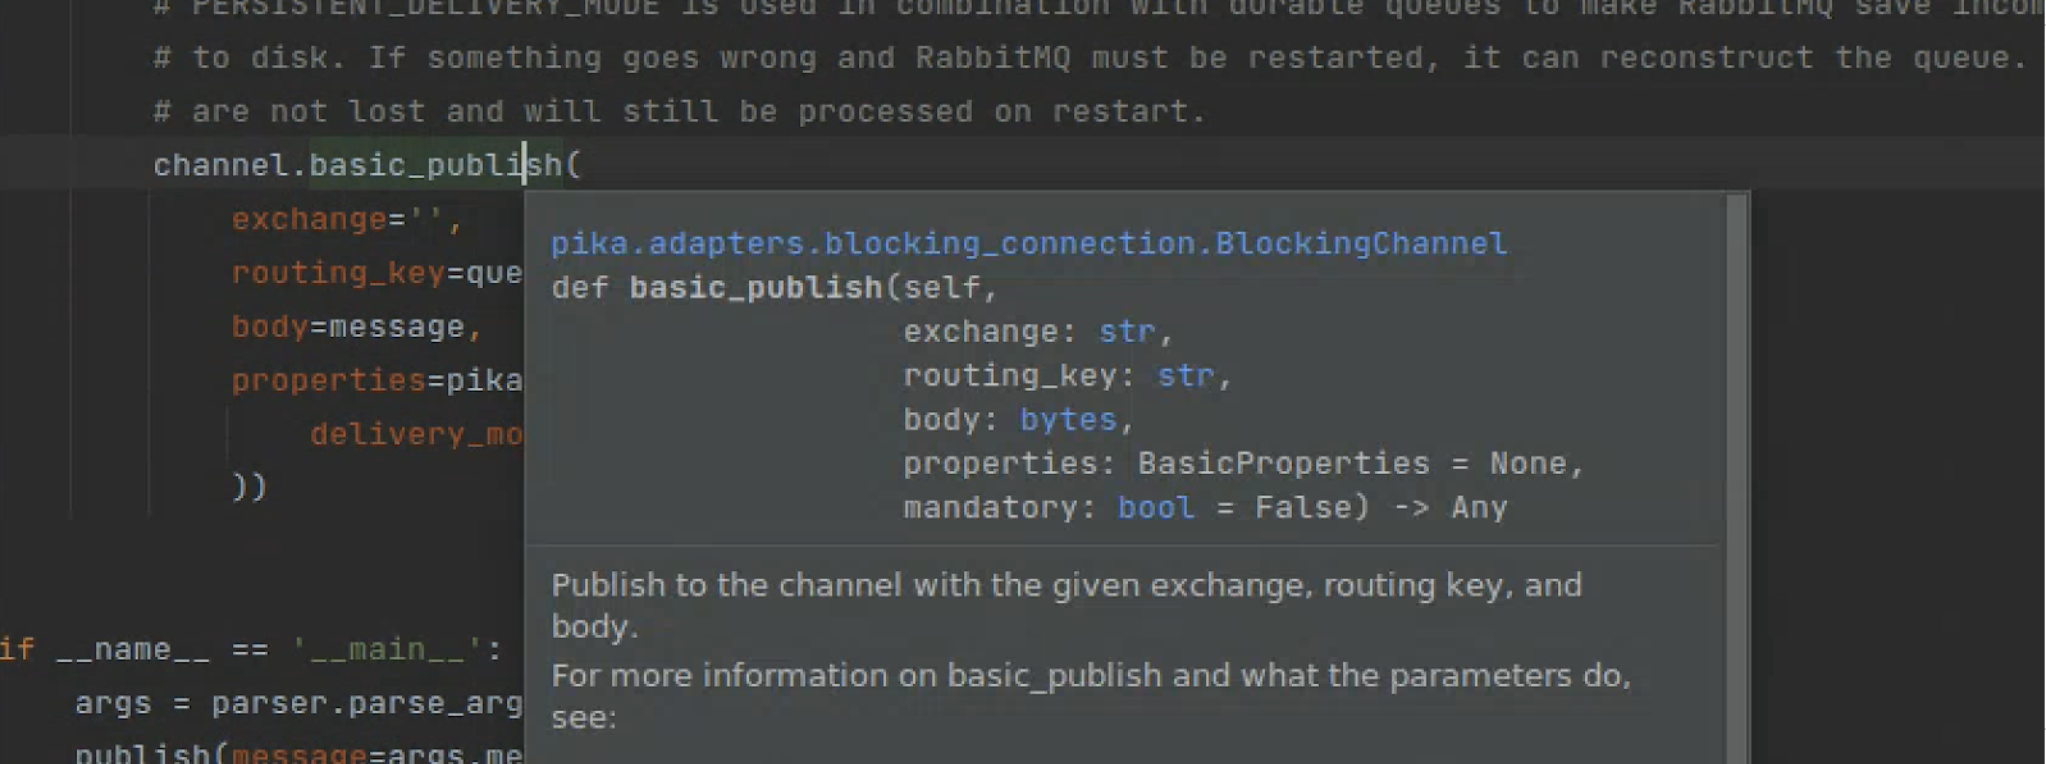

Type hints worden gebruikt om zowel gebruikers als de Python interpreter hints te geven over wat voor types bepaalde variabelen zijn. Dit zorgt ervoor dat het een stuk duidelijker is wat er in je code gebeurt en geeft veel IDE's ook de mogelijkheid warnings te geven wanneer je verkeerde types meegeeft.

In [ ]:
listener_config = {
    'rabbitmq_host': 'SRV-CDB-30',
    'listeners': [
        { 'name': 'worker1',
          'host': 'localhost' },
        { 'name': 'worker2',
          'host': 'SRV-DEV-04' }
    ]
}

In [ ]:
from typing import Any, Dict, List, Union, Optional

In [ ]:
def publish(message: str, queue: str, listener_config: Dict[str, Any]) -> str:
  print(', '.join([f'{worker["name"]} at {worker["host"]}' 
                  for worker in listener_config['listeners']]))
  return f'Message: {message} Queue: {queue} RabbitMQ Host: {listener_config["rabbitmq_host"]}'



In [ ]:
publish(message="Hello World!", queue="com-scripts", listener_config=listener_config)

worker1 at localhost, worker2 at SRV-DEV-04


'Message: Hello World! Queue: com-scripts RabbitMQ Host: SRV-CDB-30'

In [ ]:
def publish2(message: str, queue: str, 
             listener_config: Dict[str, Union[str, List[Any]]], 
             optional_argument: Optional[bool] = False) -> str:
  print(optional_argument)
  print(', '.join([f'{worker["name"]} at {worker["host"]}' 
                  for worker in listener_config['listeners']]))
  return f'Message: {message} Queue: {queue} RabbitMQ Host: {listener_config["rabbitmq_host"]}'

In [ ]:
publish2(message="Hello World!", queue="com-scripts", listener_config=listener_config)

False
worker1 at localhost, worker2 at SRV-DEV-04


'Message: Hello World! Queue: com-scripts RabbitMQ Host: SRV-CDB-30'

In [ ]:
publish2(message="Hello World!", queue="com-scripts", listener_config=listener_config, optional_argument=True)

True
worker1 at localhost, worker2 at SRV-DEV-04


'Message: Hello World! Queue: com-scripts RabbitMQ Host: SRV-CDB-30'

Colab draait Python 3.7. Nieuwere versies van Python hebben meer features standaard ingebouwd, waardoor de typing library minder vaak nodig is. De definitie van publish2 wordt in Python 3.10 bijvoorbeeld:

```python
def publish2(message: str, queue: str, 
             listener_config: dict[str, str | list[Any]], 
             optional_argument: bool | None = False) -> str:
```

## Enums

Soms is het handig om iets specifieker te zijn in wat voor argument er mag worden meegegeven. Je wilt bijvoorbeeld aan een functie de naam van een server meegeven, waar maar een beperkt aantal mogelijkheden voor zijn. 

Een manier om dit aan te pakken is met een Enum:

In [ ]:
from enum import Enum

class ServerEnum(Enum):
    com_server = 1
    cdb_server = 2


De class ServerEnum is een soort datatype wat beperkt is in de waardes die het kan hebben. In dit geval zijn de mogelijke waardes 1 en 2. Bij deze waardes horen de namen com_server en cdb_server. Je kunt het dus ook zien als een soort dictionary.

In [ ]:
ServerEnum.com_server

<ServerEnum.com_server: 1>

In [ ]:
def test_func(server: ServerEnum):
    return server


In [ ]:
test_func(ServerEnum.com_server)

<ServerEnum.com_server: 1>

## Args & Kwargs

Soms is het handig om functies extra argumenten te laten accepteren, zonder deze expliciet van te voren te definiëren. Hiervoor kun je de `*args` notatie gebruiken.

In [ ]:
def print_types(*args):
    for arg in args:
        print(type(arg))

In [ ]:
print_types(1, 'hallo')

<class 'int'>
<class 'str'>


De notatie `*args` geeft eigenlijk aan dat args een lijst is, maar dat de inhoud van deze lijst als individuele waardes moet worden 'uitgepakt' voor de functie definitie. Dit kunnen we zelf ook gebruiken:

In [ ]:
vars = [1, 'hallo']
print_types(vars)
print_types(*vars)

<class 'list'>
<class 'int'>
<class 'str'>


We kunnen `*args` alleen gebruiken om extra *positional arguments* te definiëren. De argumenten kunnen dus geen naam hebben, `print_types(var1=1, var2='hallo')` zal dus een error geven. Gelukkig is er ook een notatie voor extra *keyword arguments*, namelijk `**kwargs`.

In [ ]:
def print_types_kwargs(**kwargs):
  for key, value in kwargs.items():
    print(f'Type of {key}: {type(value)}')

In [ ]:
print_types_kwargs(var1=1, var2='hallo')

Type of var1: <class 'int'>
Type of var2: <class 'str'>


Kwargs is nu geen lijst, maar een dictionary!

## Decorators

Het komt vrij vaak voor dat er stukken code zijn die we voor meerdere functies willen herhalen. Je wilt bijvoorbeeld bij het begin en eind van de functie een log functie uitvoeren. Hieronder zijn twee functies gedefinieërd ter illustratie.

In [ ]:
from time import time

In [ ]:
def log_start():
  print(f'Started at {time()}')


def log_end():
  print(f'Ended at {time()}')

Een naïve implementatie kan als volgt zijn:

In [ ]:
def add_func(var1: int, var2: int) -> int:
  log_start()
  result = var1 + var2
  log_end()
  return result

In [ ]:
add_func(1, 2)

Started at 1660572695.1202047
Ended at 1660572695.1202977


3

Het wordt echter snel vervelend om dit overal te herhalen. Gelukkig kunnen decorators dit voorkomen:

In [ ]:
from functools import wraps

def with_log(func):
  @wraps(func)
  def log_func(*args, **kwargs):
    log_start()
    result = func(*args, **kwargs)
    log_end()
    
    return result
  
  return log_func

Een decorator is eigenlijk een functie die een andere functie accepteert als argument en een nieuwe functie teruggeeft. In dit geval accepteert het een functie en geeft het een nieuwe functie terug, waarbij de log aanroepen zijn toegevoegd. We kunnen decorators vervolgens als volgt gebruiken:

In [ ]:
@with_log
def add_func(var1, var2):
  return var1 + var2

Dit bovenstaande is eigenlijk een handige shortcut. Wat er eigenlijk gebeurt is het volgende:

```python
def add_func(var1, var2):
  return var1 + var2

add_func = with_log(add_func)
```

In [ ]:
add_func(1, 2)

Started at 1660573180.7252584
Ended at 1660573180.7269628


3

## Command Line Arguments

Met `sys.argv` kun je standaard al precies uitlezen wat er in de commandline is meegegeven bij het uitvoeren van een Python script. Dit is echter foutgevoelig en kan voor onverwacht gedrag zorden. Gelukkig kunnen we gebruik maken van de argument parser:

In [ ]:
import argparse

parser = argparse.ArgumentParser(description='My Argument Parser')

We kunnen verplichte *positional arguments* als volgt definiëren:

In [ ]:
parser.add_argument('var1')

_StoreAction(option_strings=[], dest='var1', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

Als we de commandline arguments willen verwerken roepen we `parser.parse_args()` aan. Het zal default alles achter de naam van het python script als lijst in deze functie stoppen. Voor testen kunnen we zelf deze lijst aanmaken:

In [ ]:
parser.parse_args(['test'])

Namespace(var1='test')

Dit bovenstaande is equivalent aan `parser.parse_args()` als we het script als volgt zouden aanroepen in de terminal: `python script.py test`

We kunnen ook optionele argumenten toevoegen of flags die als bool worden geïnterpreteerd:

In [ ]:
parser.add_argument('-o', '--optional')

parser.add_argument('-f', '--flag', action='store_true')
parser.add_argument('--no-flag', dest='flag', action='store_false')
parser.set_defaults(flag=False)

In Python 3.10 kunnen we de bool `--flag` een stuk korter aanmaken, namelijk:

```python
parser.add_argument('-f', '--flag', action=argparse.BooleanOptionalAction, default=False)
```

In [ ]:
parser.parse_args(['test'])

Namespace(flag=False, optional=None, var1='test')

In [ ]:
parser.parse_args(['test', '-o', 'testtest'])

Namespace(flag=False, optional='testtest', var1='test')

In [ ]:
parser.parse_args(['test', '-f'])

Namespace(flag=True, optional=None, var1='test')

# Classes & Inheritance

Naast je code opdelen in verschillende functies en scripts, kun je ook zelf *classes* aanmaken om meer structuur aan te brengen. Een class kun je zien als de definitie van een object. Door de class aan te roepen en het resultaat in een variabele te stoppen krijg je een instantie van deze class. Dit kun je vervolgens weer verder gebruiken. 

Python heeft al veel ingebouwde classes en de meeste populaire packages zijn ook uit classes opgebouwd. Zo is `list` bijvoorbeeld een class en wanneer je een list aanmaakt met bijvoorbeeld `list(1, 2, 3)` krijg je een object van deze class terug. Wat voor eigenschappen en functies (*methods*) dit object vervolgens heeft is afhankelijk van de class definitie. 

Een voorbeeld van een simpele class:

In [ ]:
import time

class SimpleWorkerClass():
  def __init__(self, name: str, addition: int = 5):
    self.name = name
    self.addition = addition

  def add_to_var(self, var: int) -> int:
   print(f'Running on worker {self.name}')
   return var + self.addition


Als de class die je definieërt iets moet doen bij initialisatie, zoals wat variabele opslaan in de class, moet dit worden gedaan door een `__init__` methode te definieren. Class methods hebben vrijwel altijd als eerste argument `self`, wat een speciale variabele is die altijd naar het object refereert wat de methode uitvoert. Vaak gebruik je dit in de `__init__` methode om argumenten op te slaan in het object.

`__init__` is een speciale *built-in method*. Als we een methode in een class aanmaken met deze naam, weet Python dat het deze methode moet uitvoeren bij initialisatie. Er zijn nog veel meer van dit soort methods en we zullen er een aantal behandelen. 

We kunnen nu als volgt deze class initialiseren:


In [ ]:
worker = SimpleWorkerClass('worker1', 2)

Deze class heeft verder nog een method: `add_to_var`. Ook deze heeft weer als eerste argument `self`, wat hier wordt gebruikt om `name` en `addition` op te halen. We hebben deze variabelen bij class initialisatie meegegeven.

In [ ]:
worker.add_to_var(2)

Running on worker worker1


4

We kunnen ook de waardes opvragen van de parameters die we aan class hebben meegegeven bij initialisatie. Deze worden ook wel *properties* genoemd.

In [ ]:
worker.addition

2

Classes zijn ook erg handig om code duplication te voorkomen. Stel dat we een tweede class willen die alles kan wat `SimpleWorkerClass` kan, maar daarnaast ook een extra parameter `multiplication` accepteert en een methode heeft om te vermenigvuldigen. In plaats van de hele class kopieëren en wat aanpassingen doen kunnen we in dit geval gebruik maken van *inheritance*. We maken een class aan die alles overneemt van de `SimpleWorkerClass` (de *parent* of *super* class), met een aantal toevoegingen of aanpassingen.

In [ ]:
class AdvancedWorkerClass(SimpleWorkerClass):
  def __init__(self, name: str, addition: int = 5, multiplication: int = 5):
    super().__init__(name, addition)
    self.multiplication = multiplication

  def __call__(self):
    return f'This worker is called {self.name}'

  def mult_var(self, var: int):
    print(f'Running on worker {self.name}')
    return var * self.multiplication

In de `__init__` methode beginnen we nu met `super().__init()`. Als we in een *sub class* een nieuwe `__init__` methode (of andere methode die al bestaat in de *super class*) definiëren overschrijft deze namelijk die van de *super class*. Met `super().__init()` roepen we echter alsnog de originele `__init__` methode aan. Wat er dus eigenlijk gebeurt is dat deze methode wordt aangevuld met het toevoegen van `self.multiplication`.

Zoals je kunt zien hebben we ook nog een *built-in method* toegevoegd, namelijk `__call__`. Door deze methode te definiëren worden objecten van deze class ook uitvoerbaar als functie. 

In [ ]:
advanced_worker = AdvancedWorkerClass('worker2', 3, 2)

In [ ]:
advanced_worker()

'This worker is called worker2'

Als we het bovenstaande uitvoeren, weet Python dat het eigenlijk `advanced_worker.__call__()` moet uitvoeren. De `__call__` functie kan verder zo complex zijn als je zelf wilt en je kunt er ook parameters aan meegeven.

Het `advanced_worker` object heeft naast deze nieuwe `__call__` methode ook nog de `mult_var` methode erbij gekregen. Hij heeft echter ook nog steeds de `add_to_var` methode, omdat het object deze meekrijgt van de *super class*.

In [ ]:
advanced_worker.mult_var(4)

Running on worker worker2


8

In [ ]:
advanced_worker.add_to_var(4)

Running on worker worker2


7

Nog een paar handige *built-in methods* om aandacht aan te besteden zijn `__enter__` en `__exit__`. Deze worden vaak gebruik in packages die connecties leggen met databases of andere systemen. In de `__enter__` methode wordt gedefinieërt hoe de verbinding moet worden gestart en in de `__exit__` methode hoe deze moet worden afgesloten. Dit stelt je vervolgens in staat de eerder genoemde `with ... as ...:` notatie te gebruiken, in plaats van handmatig verbindingen starten en stoppen. 

Een voorbeeld:

In [ ]:
import time 

class SimpleLogger():
  def __enter__(self):
    self.start_time = time.time()
    return self

  def __exit__(self, *exc_info):
    print(f'This script ran for {time.time() - self.start_time} seconds.')

In [ ]:
with SimpleLogger() as logger:
  print(logger.start_time)
  time.sleep(5)


1660638071.7305617
This script ran for 5.000385761260986 seconds.


Let op, de `__exit__` methode moet standaard 4 parameters accepteren, welke informatie bevatten over de excecutie van het `with` block. Je hoeft deze niet te gebruiken, maar je moet wel rekening met ze houden in de functie definitie. Dit is een mooi moment om de `*args` notatie te gebruiken.

# Project structuur

Er zijn meedere manieren om Python projecten te structureren en welke de beste is, is afhankelijk van de use case. We gaan vandaag kijken naar een redelijk gangbare manier om python packages te structureren. Met deze kennis kunnen we zelf packages gaan bouwen, wat veel voordelen met zich meebrengt ten opzichte van scripts aan PYTHONPATH toevoegen.

Een Pyton repository kan er als volgt uit zien:
```
/
    src/
        package_a/
            __init__.py
            module1.py
            subpackage_b/
                __init__.py
                module2.py
                module3.py 
    data/
    requirements.txt
    setup.py
    main.py
```

Deze repository bevat een package genaamd *package_a*, wat een module bevat (python files). Hiernaast bevat het ook een subpackage *package_b* met twee modules. De packages en subpackages van een project worden vaak in een aparte *src* directory houden. Daarnaast bevat de *root* folder van de repository nog *requirements.txt*, *setup.py* en *main.py*. Als er gebruik wordt gemaakt van bestanden die geen onderdeel zijn van het package worden deze vaak in een aparte directory gehouden, hier *data*. Vaak is er ook nog een aparte directory voor *unit tests*

## \_\_init\_\_.py

Een *\_\_init\_\_.py* file wordt gebruik om aan Python te signaleren dat de directory waar deze file in staat een package of subpackage is. Dit wordt onder andere gebruikt door `import` statements om te bepalen waar er wordt gekeken voor modules en door *setup.py* om te bepalen wat er geïnstalleerd moet worden (hierover later meer).

Je kunt het bestand gewoon leeg laten en vaak is het ook niet nodig er iets mee te doen. Je kunt het echter ook gebruiken om te beïnvloeden hoe `import` van modules van een package eruit zien of om modules of functies *private* te maken. Dat laatste wil zeggen dat modules en functies wel door andere modules en functies van het package zijn aan te roepen, maar niet afzonderlijk door de gebruiker van het package.

Laat de modules de volgende classes of functies bevatten:


*   *module1.py*: `SimpleWorkerClass`
*   *module2.py*: `SimpleLogger`
*   *module3.py*: `logging_helper`

We willen dat SimpleWorkerClass en SimpleLogger door een gebruiker bereikbaar zijn. De functie in module2 moeten echter verborgen worden.

We bereiken dit met het volgende in *\_\_init\_\_.py van subpackage_b:

```python
import package_a.subpackage_b.module2
```

Als we de logger willen gebruiken in code doen we nu:

```python
from package_a.subpackage_b.module2 import SimpleLogger
```

We kunnen deze `import` nog korter maken door de *\_\_init\_\_.py* van subpackage_b aan te passen naar:

```python
from package_a.subpackage_b.module2 import *
```

De logger importeren wordt dan:

```python
from package_a.subpackage_b import SimpleLogger
```

Naast het gebruik van absolute imports kunnen we ook relatieve imports gebruiken. Als we bijvoorbeeld in *module3.py* een functie van *module1.py* willen gebruiken doen we dat als volgt:

```python
import ..module1
```

De twee punten geven aan dat er moet worden gekeken in de bovenliggende directory voor de module. Met een enkele punt kan ook worden aangegeven dat er in de huidige directory moet worden gekeken.

Het aanpassen van *\_\_init\_\_.py* is vooral handig als een project groot en complex is geworden. Het is een goede gewoonte `import` statements zo kort mogelijk te houden. Als er veel subpackages zijn kan dit voor nogal lange imports zorgen zonder aanpassingen.

## setup.py

In *setup.py* staat hoe het package gebouwd of geïnstalleerd moet worden. Hiervoor gebruiken we vaak het package *setuptools*. Een setup.py van dit project kan er als volgt uit zien:

```python
import setuptools

setuptools.setup(
    name="package_a",
    version="0.0.1",
    author="Bas de Kan",
    author_email="mail@basdekan.nl",
    package_dir={"": "src"},
    packages=setuptools.find_packages(where="src"),
    python_requires=">=3.9",
    install_requires=['numpy']
)
```

Requirements voor een package kun je meegeven met het `install_requires` argument. Het is hiernaast echter ook verstandig een requirements.txt file bij te houden. Deze kun je dan makkelijk gebruiken als je aan het package aan het developen bent.

We kunnen vervolgens als alles goed staat ons package als volgt installeren vanuit de root directory van de repository:
```shell
pip install .
```

Het package wordt geïnstalleerd in je actieve virtual env. Vervolgens kun je modules, classes en functies in je andere projecten importeren en gebruiken zolang deze virtual env actief is. 

Bij wijzigingen aan het package dien je wel opnieuw `pip install` uit te voeren. Als je aan het developen bent aan het package is dit niet even handig. Daarom kun je dan beter het volgende gebruiken:
```shell
pip install -e .
```

Met de `-e` optie geef je aan dat het package in editing mode wordt geïnstalleerd. In plaats van je code deels compilen en zoveel mogelijk optimaliseren wordt bij gebruik van functies naar de python files zelf verwezen. Als je aanpassingen doet hoef je alleen opnieuw de functie te importeren (of in een enkel geval de python kernel te restarten) om de wijzigingen te gebruiken. Dit gaat echter ten kost van performance en je kan het dus beter alleen gebruiken als je actief aan het package aan het werken bent.

## main.py

Wanneer je je package ook als applicatie wil kunnen gebruiken door het vanuit de commandline uit te voeren doe je dit vaak middels een main.py script in de root folder. In dit script importeer je functionaliteiten van je package en voer je deze uit op basis van commandline arguments. Het is ook mogelijk om modules zo op te zetten dat ze ook uit te voeren zijn als scripts, maar dit is meestal niet zo een goed idee. Er zijn echter wel redenen om dit te doen. 

## Wheel

Vaak wil je een package ook kunnen samenvoegen tot een los bestand wat je kan installeren zonder de hele repository nodig te hebben. Met Python en pip werken we met *wheel* bestanden (*.whl*). 

Om een wheel bestand te maken is eerst het package *build* installeren:
```shell
pip install build
```

Vervolgens kunnen we ons package builden tot een wheel bestand met het volgende command:
```shell
python -m build --wheel
```

Het wheel bestand wat hieruit komt kan vervolgens met `pip` worden geïnstalleerd. Vaak wordt dit nog geupload naar een (private) online PyPi repository waar pip dan mee kan verbinden om het wheel bestand te downloaden en te installeren.

# Refactor PythonMods

Om de kennis in de praktijk te brengen gaan we PythonMods refactoren. Hiervoor is al een branch aangemaakt. 

Wat suggesties:

*   Alle namen van files, functies, variabele etc. volgens de pep8 standaard.
*   Loops vervangen door list comprehensions.
*   Type hinting.
*   Aparte folder met *\_\_init\_\_.py* voor hoofd package.
*   Subpackage voor SQL modules.
*   Een aantal modules zijn te herschrijven zijn als classes met methodes. Deze kunnen ook met een `__enter__` en `__exit__` methode worden gedefinieërd voor meer robuustheid.
  *   BrhMsSqlSrv.py
  *   BrhMysql.py
  *   brh_ftp.py
*   Waar een module veel functies bevat die ongerelateerd zijn aan elkaar, opdelen in meerde modules.
*   Vrij specifieke functies generieker maken.
*   *utils.py* in repository *cdb-scripts* naar PythonMods.
*   Aanpassingen aan naamgeving functies en variabelen voor consistentie en duidelijkheid.